In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import choice
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [90]:
tdf = pd.read_csv('StormEvents_details_WORKING.csv')

In [99]:
tdf['BEGIN_YEAR'] = tdf['BEGIN_YEARMONTH'].apply(lambda ym : int(str(ym)[0:4]))
tdf['BEGIN_DECADE'] = (tdf['BEGIN_YEAR'] // 10) * 10
tdf['BEGIN_MONTH'] = tdf['BEGIN_YEARMONTH'].apply(lambda ym : int(str(ym)[-2:]))
tdf.rename({'Unnamed: 0':'STORM_ID'},axis=1,inplace=True)

Text(0.5, 1.0, 'Month')

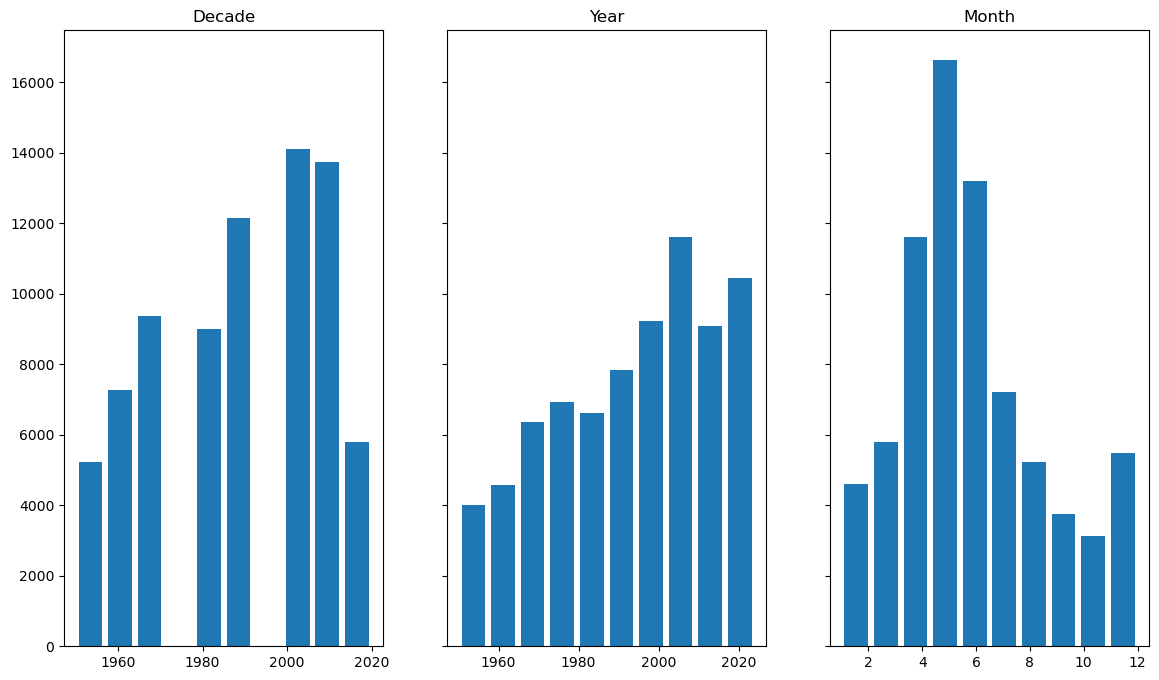

In [115]:
fig, axs = plt.subplots(1,3,figsize=(14,8),sharey=True)


axs[0].hist(
    tdf.BEGIN_DECADE,
    rwidth=.8
)
axs[0].set_title('Decade')

axs[1].hist(
    tdf.BEGIN_YEAR,
    rwidth=.8
)
axs[1].set_title('Year')

axs[2].hist(
    tdf.BEGIN_MONTH,
    rwidth=.8
)
axs[2].set_title('Month')


In [117]:
# wait, why aren't the 70s the 
tdf.BEGIN_YEAR.value_counts(normalize=True)

BEGIN_YEAR
2011    0.027044
2008    0.025480
2004    0.025388
2019    0.022611
2017    0.021529
          ...   
1953    0.006416
1952    0.003547
1951    0.003508
1950    0.002908
2024    0.001356
Name: proportion, Length: 75, dtype: float64

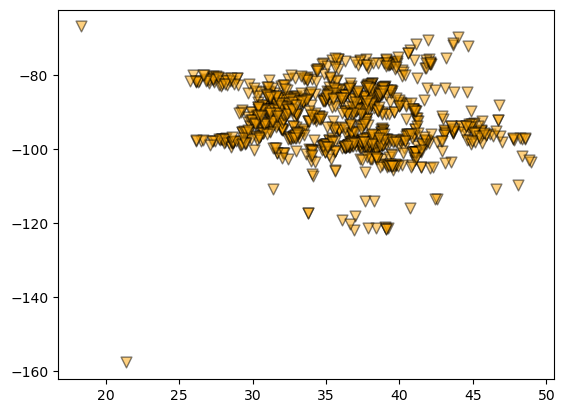

In [4]:
#[_ for _ in range(1950,2025)]
for yr in [2012]:
    data = tdf[tdf['BEGIN_YEAR'] == yr]
    plt.scatter(data['BEGIN_LAT'],
                data['BEGIN_LON'],
                label=str(yr),
                marker='v',
                s=60,
                alpha=.5,
                edgecolor='black',
                c='orange')

# CONVEX HULL CALCULATIONS
```
algorithm jarvis(S) is
    // S is the set of points
    // P will be the set of points which form the convex hull. Final set size is i.
    pointOnHull = leftmost point in S // which is guaranteed to be part of the CH(S)
    i := 0
    repeat
        P[i] := pointOnHull
        endpoint := S[0]      // initial endpoint for a candidate edge on the hull
        for j from 0 to |S| do
            // endpoint == pointOnHull is a rare case and can happen only when j == 1 and a better endpoint has not yet been set for the loop
            if (endpoint == pointOnHull) or (S[j] is on left of line from P[i] to endpoint) then
                endpoint := S[j]   // found greater left turn, update endpoint
        i := i + 1
        pointOnHull = endpoint
    until endpoint = P[0]      // wrapped around to first hull point
```

In [5]:
class Point:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
    
def leftmost_point(points):
    return min(points, key = lambda p: p.x)

def is_ccw(p0,p1,p2):
    # returns true if p1 is ccw to p0 relative to p2
    A = np.array([p0.x,p0.y])
    B = np.array([p1.x,p1.y])
    C = np.array([p2.x,p2.y])
    return np.cross(B - A, C - A) < 0

def convex_hull(point_list):
    first_point = leftmost_point(point_list)
    hull_ids = [point_list.index(first_point)]
    start = leftmost_point(point_list)

    target = choice(point_list)
    while target == start:
        target = choice(point_list)
    working_pl = point_list.copy()

    while first_point.id != target.id:
        target = working_pl[0]
        for p in working_pl:
            if (is_ccw(start,p,target)):
                target = p
        hull_ids.append(point_list.index(target))
        start = target
        del(working_pl[working_pl.index(target)])
    return hull_ids


In [73]:

decades = tdf.BEGIN_DECADE.unique()
decade_hulls = {}

for dec in decades: 
    decade_data = tdf[(tdf['BEGIN_DECADE'] == dec)]
    point_list = [Point(*p) for p in zip(decade_data.index, decade_data.BEGIN_LAT, decade_data.BEGIN_LON)]
    hull_ids = convex_hull(point_list)
    decade_hulls[dec] = hull_ids

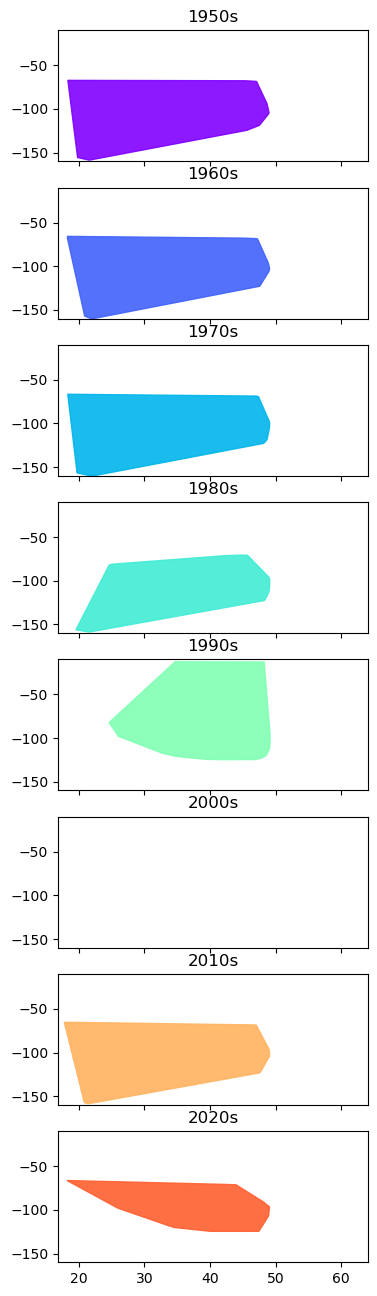

In [74]:
cmap = plt.get_cmap('rainbow')
color_decade_hulls = {}
length = len(decade_hulls) 
for idx, decade in enumerate(decade_hulls.keys()):
    color = list(cmap(idx / length)) # the same as normalizing #
    color[3] = .9    # adds a 20% opacity to the colors
    color_decade_hulls[decade] = {
        'color': color,
        'hull_ids': decade_hulls[decade]
    }
fig, ax = plt.subplots(length,1, sharex=True, sharey=True, figsize=(4,16))

patches = []
idx = 0
for decade, data in color_decade_hulls.items():
    hull_ids = data['hull_ids']
    
    decade_data = tdf[(tdf['BEGIN_DECADE'] == decade)]
    point_list = [Point(*p) for p in zip(decade_data.index, decade_data.BEGIN_LAT, decade_data.BEGIN_LON)]

    polygon = Polygon([[point_list[i].x,point_list[i].y] for i in hull_ids], closed=True, color = data['color'])
    p = PatchCollection([polygon], match_original=True)
    ax[idx].add_collection(p)
    ax[idx].set_title(str(decade) + 's')
    idx +=1

ax = plt.gca()
ax.set_xlim([tdf['BEGIN_LAT'].min() * .95, tdf['BEGIN_LAT'].max() * 1.05])
ax.set_ylim([-160, -10])

plt.show()

In [67]:
tdf.BEGIN_DECADE.value_counts(normalize=True).sort_values()

BEGIN_DECADE
1950    0.068296
2020    0.074601
1960    0.094899
1980    0.117586
1970    0.122324
1990    0.158691
2010    0.179329
2000    0.184276
Name: proportion, dtype: float64

In [76]:
tdf[tdf['BEGIN_DECADE'] == 2000]

,Unnamed: 0,BEGIN_YEARMONTH,BEGIN_DAY,END_YEARMONTH,END_DAY,EVENT_ID,STATE,STATE_FIPS,EVENT_TYPE,CZ_TYPE,...,DAMAGE_PROPERTY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,BEGIN_LAT,BEGIN_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,BEGIN_YEAR,BEGIN_DECADE
43038,420817,200002,24,200002,24,5130281,OKLAHOMA,40.0,Tornado,C,...,90K,F1,8.00,150.0,NaN,NaN,NaN,This tornado formed in northeast Lipscomb Coun...,2000,2000
43039,421099,200001,3,200001,3,5129129,INDIANA,18.0,Tornado,C,...,47K,F1,0.30,50.0,NaN,NaN,NaN,A tornado touched down in Washington county no...,2000,2000
43040,421900,200002,22,200002,22,5129550,TEXAS,48.0,Tornado,C,...,NaN,F0,0.10,0.1,NaN,NaN,NaN,A brief tornado occurred at the Flying L Ranch...,2000,2000
43041,421903,200002,22,200002,22,5129553,TEXAS,48.0,Tornado,C,...,15K,F0,12.00,0.5,NaN,NaN,NaN,A boat storage building was unroofed and a wal...,2000,2000
43042,422180,200002,14,200002,14,5132160,GEORGIA,13.0,Tornado,C,...,2M,F2,5.00,200.0,31.3000,-83.63333,NaN,A strong tornado crossed U.S. Highway 319 from...,2000,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57150,975288,200906,5,200906,5,166964,NEBRASKA,31.0,Tornado,C,...,0.00K,EF0,0.10,30.0,41.4891,-103.94650,A few severe thunderstorms produced hail and a...,Small tornado briefly touched down over open r...,2009,2000
57151,975296,200906,9,200906,9,167430,NEBRASKA,31.0,Tornado,C,...,0.00K,EF0,0.10,30.0,41.2200,-103.32000,"A small tornado briefly developed near Potter,...","Tornado briefly touched down, then dissipated.",2009,2000
57152,975304,200906,7,200906,7,193392,NEBRASKA,31.0,Tornado,C,...,0.00K,EF0,0.50,25.0,41.6331,-104.01820,A line of thunderstorms produced hail over eas...,Brief tornado touchdown 15 miles west northwes...,2009,2000
57153,975307,200906,5,200906,5,166961,WYOMING,56.0,Tornado,C,...,10.00K,EF2,8.31,100.0,41.6300,-104.38300,Scattered severe thunderstorms produced large ...,A widely observed tornado moved across open co...,2009,2000


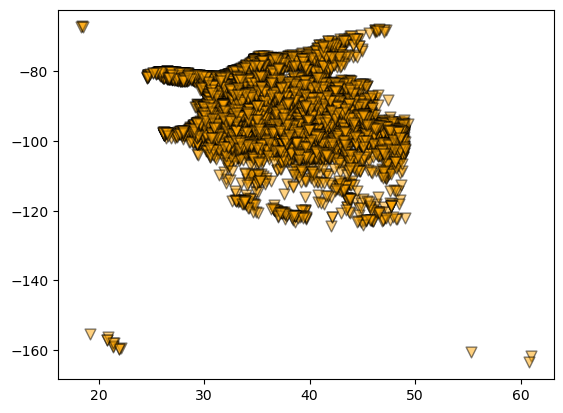

In [77]:

decade_data = tdf[(tdf['BEGIN_DECADE'] == 2000)]
point_list = [Point(*p) for p in zip(decade_data.index, decade_data.BEGIN_LAT, decade_data.BEGIN_LON)]
hull_ids = convex_hull(point_list)
decade_hulls[dec] = hull_ids

X = [p.x for p in point_list]
y = [p.y for p in point_list]

fig, ax = plt.subplots()

patches = []
polygon = Polygon([[point_list[i].x,point_list[i].y] for i in hull_ids], closed=True, color = '#ff0000')
patches.append(polygon)

colors = 100 * np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4, match_original=True)
ax.add_collection(p)

ax.scatter(X,
            y,
            label=str(yr),
            marker='v',
            s=60,
            alpha=.5,
            edgecolor='black',
            c='orange')

plt.show()

In [80]:
convex_hull(point_list)

[0, 0]